In [1]:
import yfinance as yf
from datetime import datetime
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [2]:
start_date = '2010-01-01'
end_date = datetime.now().strftime('%Y-%m-%d')

aramco_stock = yf.download('2222.SR', start=start_date, end=end_date)

[*********************100%***********************]  1 of 1 completed


In [3]:
aramco_stock.head()

Price,Adj Close,Close,High,Low,Open,Volume
Ticker,2222.SR,2222.SR,2222.SR,2222.SR,2222.SR,2222.SR
Date,,,,,,
2019-12-11,24.670721,29.090908,29.090908,29.090908,29.090908,38289394
2019-12-12,25.792120,30.413223,31.983471,29.752066,31.983471,505692621
2019-12-15,26.212639,30.909090,30.991735,30.413223,30.661158,98349281
2019-12-16,26.633163,31.404959,31.487602,30.991735,30.991735,105973907
2019-12-17,26.457949,31.198347,31.528925,30.991735,31.446280,142672245


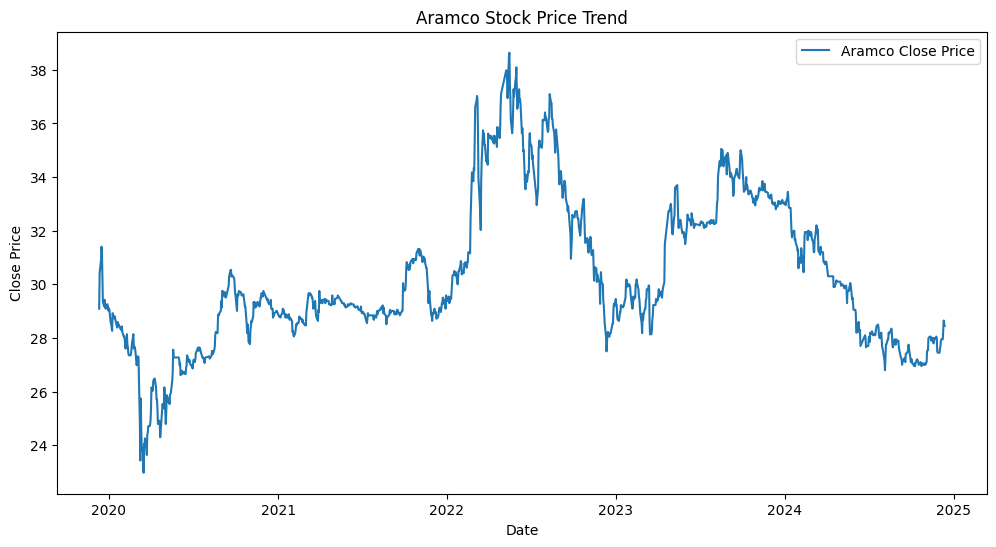

In [4]:
plt.figure(figsize=(12, 6))
plt.plot(aramco_stock['Close'], label='Aramco Close Price')
plt.title('Aramco Stock Price Trend')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [5]:
# Set Date as index if not already
if 'Date' not in aramco_stock.columns:
    aramco_stock['Date'] = aramco_stock.index
aramco_stock.set_index('Date', inplace=True)

aapl_prices = aramco_stock['Close'].values.reshape(-1, 1)

# Scale data
scaler = MinMaxScaler()
aapl_prices_scaled = scaler.fit_transform(aapl_prices)
joblib.dump(scaler, "aramco_stock_5.joblib")  # Save the fitted scaler


# Split data into training and testing sets (80% train, 20% test)
train_size = int(len(aapl_prices_scaled) * 0.8)
train_data = aapl_prices_scaled[:train_size]
test_data = aapl_prices_scaled[train_size:]

# Create sequences for LSTM model
def create_sequences(data, seq_length):
    sequences = []
    labels = []

    for i in range(len(data) - seq_length - 5 + 1):
        sequences.append(data[i:i + seq_length])
        labels.append(data[i + seq_length:i + seq_length + 5])

    return np.array(sequences), np.array(labels)

seq_length = 100
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

In [6]:
# Build LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(5))

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

c:\Users\omar\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 100, 50)        │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,005 (125.02 KB)

 Trainable params: 32,005 (125.02 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# Early stopping to prevent overfitting and stop training when validation loss stops improving
early_stopping = EarlyStopping(
    monitor='val_loss',    # Monitor validation loss
    patience=10,           # Number of epochs with no improvement before stopping
    restore_best_weights=True  # Restore the best weights after stopping
)

# Model checkpoint to save the best model during training
model_checkpoint = ModelCheckpoint(
    filepath='best_lstm_model_5.keras',  # Filepath to save the model
    monitor='val_loss',            # Monitor validation loss
    save_best_only=True,           # Save only when the model is the best
    verbose=1                      # Print saving info
)

# Reduce learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',            # Monitor validation loss
    factor=0.5,                    # Reduce learning rate by a factor of 0.5
    patience=5,                    # Number of epochs with no improvement before reducing
    min_lr=1e-6,                   # Minimum learning rate
    verbose=1                      # Print learning rate reduction info
)

# Combine callbacks into a list
callbacks = [early_stopping, model_checkpoint, reduce_lr]


In [8]:
history = model.fit(
    X_train, 
    y_train, 
    batch_size=8, 
    epochs=50, 
    validation_data=(X_test, y_test), 
    callbacks=callbacks  # Include callbacks in training
)


Epoch 1/50
111/112 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0481
Epoch 1: val_loss improved from inf to 0.00199, saving model to best_lstm_model_5.keras
112/112 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 0.0476 - val_loss: 0.0020 - learning_rate: 0.0010
Epoch 2/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0035
Epoch 2: val_loss did not improve from 0.00199
112/112 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0035 - val_loss: 0.0021 - learning_rate: 0.0010
Epoch 3/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0029
Epoch 3: val_loss did not improve from 0.00199
112/112 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0029 - val_loss: 0.0032 - learning_rate: 0.0010
Epoch 4/50
111/112 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0034
Epoch 4: val_loss improved from 0.00199 to 0.00175, saving model to best_lstm_model_5.keras
112/112 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0034 - val_loss: 0.0017 - learning_rate: 0.0010
Epoch 5/50
110/112 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step -

In [9]:
# Make predictions
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step


In [10]:
# Evaluate model performance
y_test_reshaped = y_test.squeeze()

def evaluate_model(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"RMSE: {rmse}, MAE: {mae}, R2: {r2}")

evaluate_model(y_test_reshaped, predictions)

RMSE: 27.56976420441999, MAE: 27.560939285321524, R2: -349317.4107210853


[*********************100%***********************]  1 of 1 completed

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


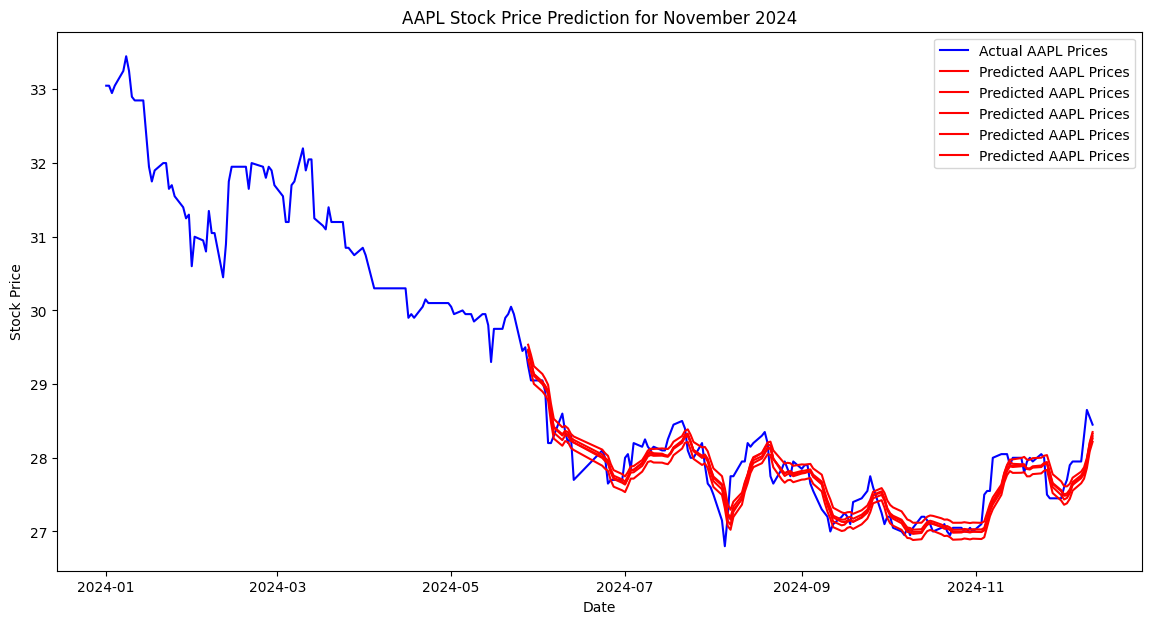

In [11]:
# Fetch data from Yahoo Finance
end_date = datetime.now().strftime('%Y-%m-%d')

aapl = yf.download("2222.SR", start="2024-01-01", end=end_date)
aapl['Date'] = aapl.index
aapl_prices = aapl['Close'].values.reshape(-1, 1)

# Scale the data using the same scaler
# scaler = MinMaxScaler()
aapl_prices_scaled = scaler.transform(aapl_prices)

# Create sequences for prediction
seq_length = 100
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+seq_length])
    return np.array(sequences)

X_future = create_sequences(aapl_prices_scaled, seq_length)

# Predict November 2024 stock prices
predictions = model.predict(X_future)
predictions_rescaled = scaler.inverse_transform(predictions)

# Plot real vs predicted prices
plt.figure(figsize=(14, 7))
plt.plot(aapl['Date'], aapl['Close'], label="Actual AAPL Prices", color='blue')
plt.plot(aapl['Date'][seq_length:], predictions_rescaled, label="Predicted AAPL Prices", color='red')
plt.title("AAPL Stock Price Prediction for November 2024")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.legend()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


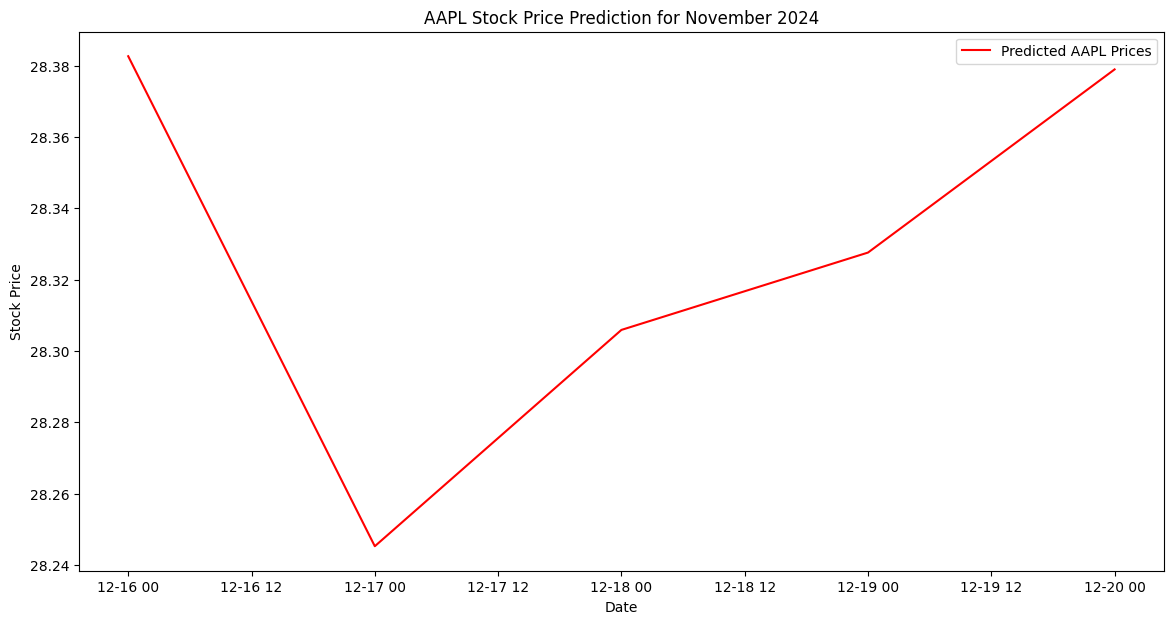

In [13]:
seq_length=100
# Prepare future prediction sequence
X_future = aapl_prices_scaled[-seq_length:].reshape(1, seq_length, 1)

# Predict November 2024 stock prices
predictions = model.predict(X_future)
predictions_rescaled = scaler.inverse_transform(predictions)

# Generate future dates for plotting
# future_dates = pd.date_range(start=datetime.now().strftime('%Y-%m-%d'), periods=11, freq='B')[1:]  # Exclude last known date

# Generate future dates from 14-12-2024 to 24-12-2024

future_dates = pd.date_range(start="2024-12-14", end="2024-12-22", freq='B')



# Plot the real vs. predicted prices
plt.figure(figsize=(14, 7))
plt.plot(future_dates, predictions_rescaled.flatten(), label="Predicted AAPL Prices", color='red')  # Predicted
plt.title("AAPL Stock Price Prediction for November 2024")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.legend()
plt.show()